In [ ]:
!unrar x "/content/drive/MyDrive/Classification_Covid_19/Data.rar" "/content/drive/MyDrive/Classification_Covid_19"

In [1]:
import os.path
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from pathlib import Path
import pandas as pd
import os
from matplotlib.pyplot import plot, figure, title, show, subplots, imread, tight_layout, title, ylim, xticks, yticks, imshow, xlabel, ylabel
import seaborn as sns
import numpy as np
from time import perf_counter
from sklearn.metrics import classification_report,accuracy_score
from tensorflow.keras.callbacks import EarlyStopping
import time
from tensorflow.keras.callbacks import TensorBoard

In [2]:
path_train = Path('/content/drive/MyDrive/Classification_Covid_19/Data/train')
path_val = Path('/content/drive/MyDrive/Classification_Covid_19/Data/test')
path_test = Path('/content/drive/MyDrive/Classification_Covid_19/test_1')

trainDir = list(path_train.glob(r'**/*.jpg'))
valDir = list(path_val.glob(r'**/*.jpg'))
testDir = list(path_test.glob(r'**/*.jpg'))

print("Number images in file train:", len(trainDir))
print("Number images in file validation:", len(valDir))
print("Number images in file test:", len(testDir))

Number images in file train: 5144
Number images in file validation: 1288
Number images in file test: 315


In [3]:
def proc_img(filepath):
  labels = [str(filepath[i]).split("/")[-2] \
            for i in range(len(filepath))]
  
  filepath = pd.Series(filepath, name= 'Filepath').astype(str)
  labels = pd.Series(labels, name= 'Labels')

  df = pd.concat([filepath, labels], axis= 1)
  df = df.sample(frac =1, random_state = 0).reset_index(drop = True)
  return df

train_df = proc_img(trainDir)
val_df = proc_img(valDir)

#train_df = pd.concat([train_df, val_df]).reset_index(drop = True)
test_df = proc_img(testDir)

print("Number images for train:", len(trainDir))
print("Number images for validation:", len(valDir))
print("Number images for testing:", len(testDir))

print("Number image diffence:", len(train_df.Labels.unique()))
print("Labels:")
print(train_df.Labels.unique())

#train_df.head(10)

Number images for train: 5144
Number images for validation: 1288
Number images for testing: 315
Number image diffence: 3
Labels:
['PNEUMONIA' 'COVID19' 'NORMAL']


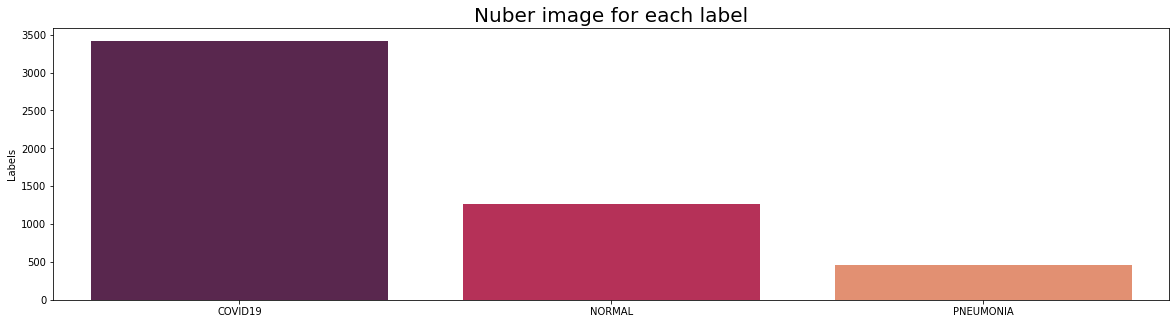

In [4]:
vc = train_df['Labels'].value_counts()
figure(figsize=(20,5))
sns.barplot(x=sorted(vc.index), y=vc, palette="rocket")
title("Nuber image for each label", fontsize = 20)
show()

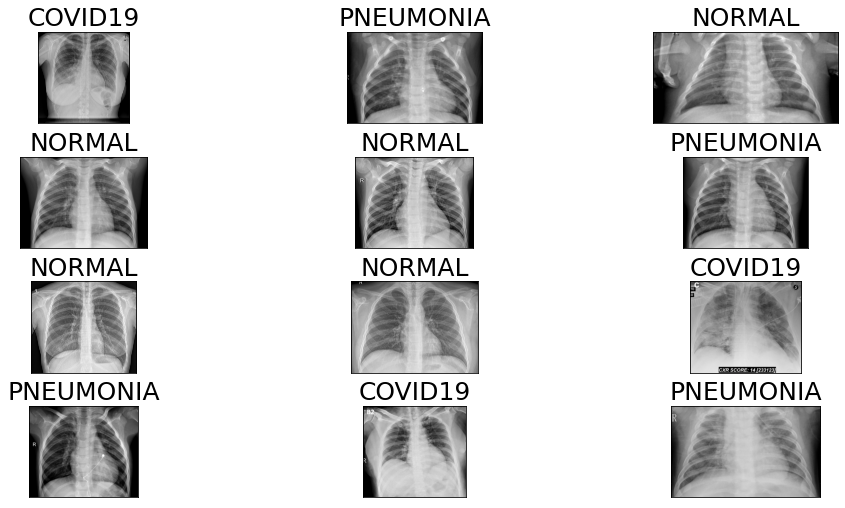

In [8]:
fig, axes = subplots(nrows = 4,
                    ncols = 3,
                    figsize = (15,7),
                    subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(imread(test_df.Filepath[i]), cmap='gray')
  ax.set_title(test_df.Labels[i], fontsize = 25)
tight_layout(pad = 0.5)
show()


In [9]:
TrainDatagen = ImageDataGenerator(rescale=1./255,validation_split=0.1)
TestDatagen = ImageDataGenerator(rescale=1./255)

train_images = TrainDatagen.flow_from_dataframe(dataframe=train_df,
                                                x_col = 'Filepath',
                                                y_col = 'Labels',
                                                target_size = (150,150),
                                                color_mode = 'rgb',
                                                class_mode = 'categorical',
                                                batch_size = 20,
                                                shuffle = True, 
                                                seed = 0)
validation_images = TestDatagen.flow_from_dataframe(dataframe=val_df,
                                                x_col = 'Filepath',
                                                y_col = 'Labels',
                                                target_size = (150,150),
                                                color_mode = 'rgb',
                                                class_mode = 'categorical',
                                                batch_size = 20,
                                                shuffle = True, 
                                                seed = 0)
test_images = TestDatagen.flow_from_dataframe(dataframe= test_df,
                                                x_col = 'Filepath',
                                                y_col = 'Labels',
                                                target_size = (150,150),
                                                color_mode = 'rgb',
                                                class_mode = 'categorical',
                                                batch_size = 20,
                                                seed = 0)

Found 5144 validated image filenames belonging to 3 classes.
Found 1288 validated image filenames belonging to 3 classes.
Found 315 validated image filenames belonging to 3 classes.


In [ ]:
def get_model(model):
  kwargs = {'input_shape': (224,224,3),
            'include_top': False,
            'weights': 'imagenet',
            'pooling': 'avg'}
  pretrained_model = model(**kwargs)
  pretrained_model.trainable = False

  inputs = pretrained_model.input
  
  x = tf.keras.layers.Dense(256, activation='relu')(pretrained_model.output)
  
  x = tf.keras.layers.Dense(128, activation='relu')(x)

  outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

  model = tf.keras.Model(inputs = inputs, outputs = outputs)
  model.compile(optimizer = 'adam',
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  return model

In [ ]:
models = {"DenseNet121":{"model": tf.keras.applications.DenseNet121, "perf": 0},
          "DenseNet169":{"model": tf.keras.applications.DenseNet169, "perf": 0},
          "DenseNet201":{"model": tf.keras.applications.DenseNet201, "perf": 0},
          "MobileNet":{"model": tf.keras.applications.MobileNet, "perf": 0},
          "MobileNetV2":{"model": tf.keras.applications.MobileNetV2, "perf": 0},
          "MobileNetV3Large":{"model": tf.keras.applications.MobileNetV3Large, "perf": 0},
          "MobileNetV3Small":{"model": tf.keras.applications.MobileNetV3Small, "perf": 0},
          "EfficientNetB0":{"model": tf.keras.applications.EfficientNetB0, "perf": 0},
          "EfficientNetB1":{"model": tf.keras.applications.EfficientNetB1, "perf": 0},
          "EfficientNetB2":{"model": tf.keras.applications.EfficientNetB2, "perf": 0},
          "EfficientNetB3":{"model": tf.keras.applications.EfficientNetB3, "perf": 0},
          "EfficientNetB4":{"model": tf.keras.applications.EfficientNetB4, "perf": 0},
          "EfficientNetB5":{"model": tf.keras.applications.EfficientNetB5, "perf": 0},
          "EfficientNetB6":{"model": tf.keras.applications.EfficientNetB6, "perf": 0},
          "EfficientNetB7":{"model": tf.keras.applications.EfficientNetB7, "perf": 0},
          "ResNet101":{"model": tf.keras.applications.ResNet101, "perf": 0},
          "ResNet101V2":{"model": tf.keras.applications.ResNet101V2, "perf": 0},
          "ResNet152":{"model": tf.keras.applications.ResNet152, "perf": 0},
          "ResNet152V2":{"model": tf.keras.applications.ResNet152V2, "perf": 0},
          "ResNet50":{"model": tf.keras.applications.ResNet50, "perf": 0},
          "ResNet50V2":{"model": tf.keras.applications.ResNet50V2, "perf": 0},
          "VGG16":{"model": tf.keras.applications.VGG16, "perf": 0},
          "VGG19":{"model": tf.keras.applications.VGG19, "perf": 0},
          "Xception":{"model": tf.keras.applications.Xception, "perf": 0}}

for name, model in models.items():
  m = get_model(model['model'])
  models[name]['model'] = m

  start = perf_counter()

  history = m.fit(train_images, validation_data = validation_images, epochs = 1, verbose = 0)

  duration = perf_counter() - start
  duration = round(duration, 3)

  models[name]['perf'] = duration
  print(f"{name:28} trained in {duration} sec")

  val_acc = history.history['val_accuracy']
  models[name]['val_acc'] = [round(v,4) for v in val_acc]

In [ ]:
for name, model in models.items():
  pred = models[name]['model'].predict(test_images)
  pred = np.argmax(pred, axis = 1)

  labels = (train_images.class_indices)
  labels = dict((v,k) for k, v in labels.items())

  pred = [labels[k] for k in pred]
  #print(pred[:5])
  y_test = list(test_df.Labels)
  acc = accuracy_score(y_test,pred)
  models[name]['acc'] = round(acc,4)

In [ ]:
model_result = []

for name, v in models.items():
  model_result.append([name, 
                       models[name]['val_acc'][-1],
                       models[name]['acc'],
                       models[name]['perf']])
df_result = pd.DataFrame(model_result,
                         columns = ['Model', 'Val_accuracy', 'Accuracy', 'Training time'])
df_result.sort_values(by = 'Accuracy', ascending = False, inplace = True)
df_result.reset_index(inplace=True, drop=True)
df_result

In [ ]:
figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Accuracy', data = df_result)
title('Accuracy (after 1 epoch)', fontsize = 15)
ylim(0.1)
xticks(rotation=90)
show()

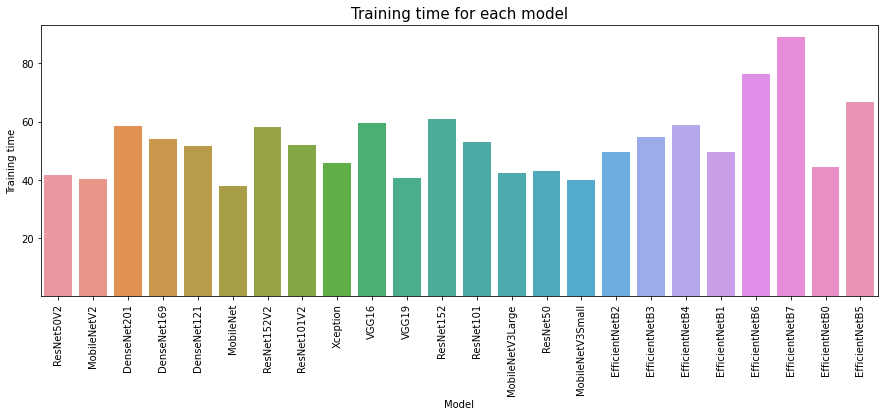

In [ ]:
figure(figsize = (15,5))
sns.barplot(x = 'Model', y = 'Training time', data = df_result)
title('Training time for each model', fontsize = 15)
ylim(0.1)
xticks(rotation=90)
show()

In [ ]:
df_result

In [ ]:
acc = df_result.iloc[0]['Accuracy']
best_model = df_result.iloc[0]['Model']
print(f'# Best model:{best_model}')
print(f'# Accuracy:{acc * 100:.2f}%')

# Best model:ResNet50V2
# Accuracy:92.09%


In [ ]:
pred = models[best_model]['model'].predict(test_images)
pred = np.argmax(pred, axis = 1)

labels = (train_images.class_indices)
labels = dict((v,k) for k, v in labels.items())

pred = [labels[k] for k in pred]
print(pred[:5])
y_test = list(test_df.Labels)
acc = accuracy_score(y_test,pred)
models[name]['acc'] = round(acc,4)

['Pneumonia', 'Covid-19', 'Normal', 'Covid-19', 'Pneumonia']


In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize = 'true')
figure(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), cbar = False)
title('Normalized Confusion Matrix\n ', fontsize=23)
xticks(fontsize=12)
xlabel("Predicted", fontsize = 20)
ylabel("Actual", fontsize = 20)
yticks(fontsize=12)
show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred))

PRE-TRAINED

In [ ]:
model_pre = get_model(tf.keras.applications.ResNet50)
#model.summary()
history = model_pre.fit(train_images, validation_data = validation_images, epochs = 10)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
258/258 [==============================] - 3440s 13s/step - loss: 0.7679 - accuracy: 0.6732 - val_loss: 0.7575 - val_accuracy: 0.6972
Epoch 2/10
108/258 [===========>..................] - ETA: 3:23 - loss: 0.6387 - accuracy: 0.7106

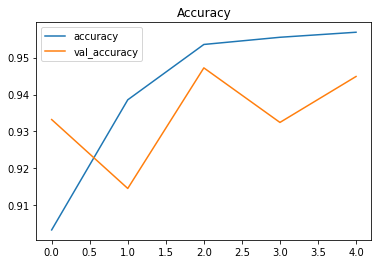

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
title("Accuracy")
show()

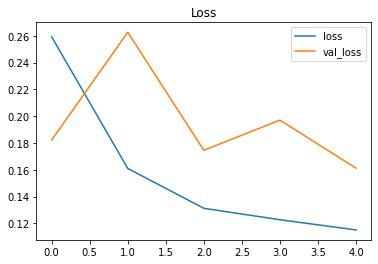

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
title("Loss")
show()

In [ ]:
pred = model_pre.predict(train_images)
pred = np.argmax(pred, axis = 1)

labels = (train_images.class_indices)
labels = dict((v,k) for k, v in labels.items())

pred = [labels[k] for k in pred]

y_test = list(train_df.Labels)
acc = accuracy_score(y_test,pred)

print(f'# Accuracy on the the test: {acc * 100:.2f}%')


# Accuracy on the the test: 52.35%


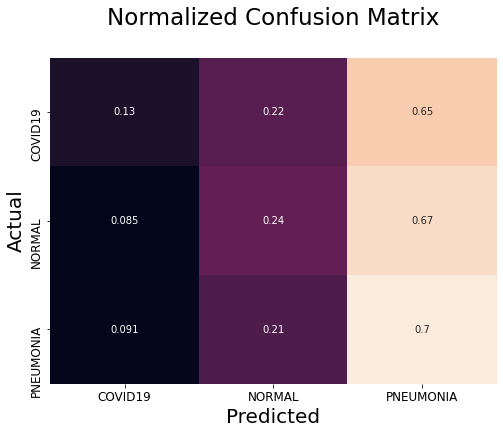

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, pred, normalize = 'true')
figure(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)), cbar = False)
title('Normalized Confusion Matrix\n ', fontsize=23)
xticks(fontsize=12)
xlabel("Predicted", fontsize = 20)
ylabel("Actual", fontsize = 20)
yticks(fontsize=12)
show()

In [ ]:
model.save('/content/drive/MyDrive/Classification_Covid_19/train_3classes_18-8.h')

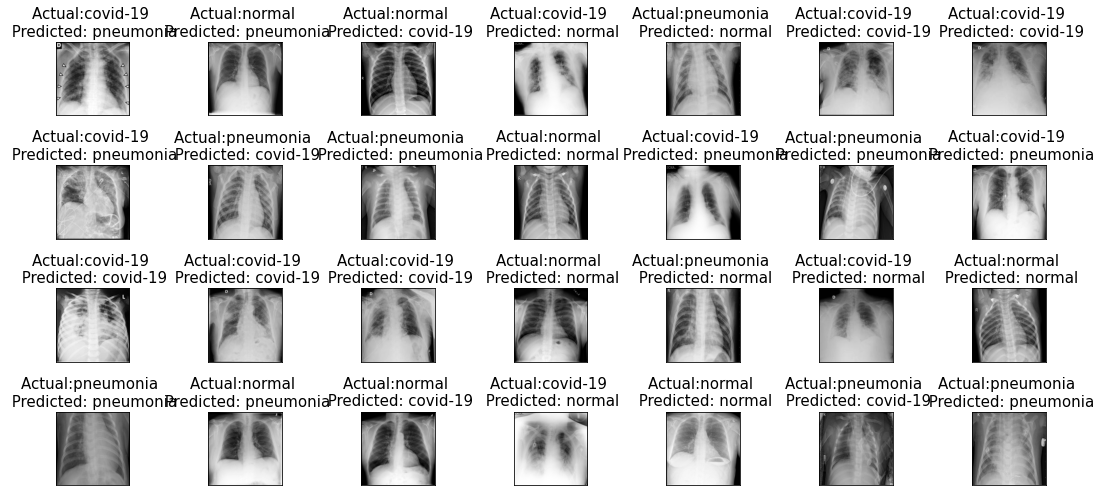

In [ ]:
fig, axes = subplots(nrows = 4,
                     ncols = 7,
                     figsize = (15,7),
                     subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(imread(test_df.Filepath.iloc[i]), cmap = 'gray')
  ax.set_title(f"Actual:{test_df.Labels.iloc[i]} \n Predicted: {pred[i]}", fontsize = 15)
tight_layout()
show()

**MODEL CUSTOM**

In [13]:
model = Sequential()

model.add(Conv2D(64, (1,1), strides = (1,1), input_shape = (150, 150, 3),padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(128, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.5))

model.add(Conv2D(512, (3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())

model.add(Dense(512, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation = 'softmax'))

model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 64)      256       
_________________________________________________________________
activation_12 (Activation)   (None, 150, 150, 64)      0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 64)        0         
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 35, 35, 64)        36928     
_________________________________________________________________
activation_13 (Activation)   (None, 35, 35, 64)       

In [ ]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit_generator(train_images, 
                              validation_data = validation_images, 
                              epochs=20, 
                              steps_per_epoch = len(train_images),
                              validation_steps = len(validation_images))

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
258/258 [==============================] - 1737s 7s/step - loss: 0.7987 - accuracy: 0.6767 - val_loss: 0.8251 - val_accuracy: 0.6638
Epoch 2/20
258/258 [==============================] - 290s 1s/step - loss: 0.4629 - accuracy: 0.8171 - val_loss: 0.4705 - val_accuracy: 0.8719
Epoch 3/20
258/258 [==============================] - 289s 1s/step - loss: 0.3458 - accuracy: 0.8701 - val_loss: 0.3070 - val_accuracy: 0.9022
Epoch 4/20
258/258 [==============================] - 291s 1s/step - loss: 0.3003 - accuracy: 0.8896 - val_loss: 0.2464 - val_accuracy: 0.9239
Epoch 5/20
258/258 [==============================] - 298s 1s/step - loss: 0.2865 - accuracy: 0.9001 - val_loss: 0.2142 - val_accuracy: 0.9247
Epoch 6/20
258/258 [==============================] - 299s 1s/step - loss: 0.2464 - accuracy: 0.9160 - val_loss: 0.1896 - val_accuracy: 0.9332
Epoch 7/20
258/258 [==============================] - 297s 1s/step - loss: 0.2376 - accuracy: 0.9185 - val_loss: 0.2123 - val_accuracy: 0.924

In [ ]:
model_custom.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_custom = model_custom.fit(train_images, 
                                  validation_data = validation_images, 
                                  epochs=1)

In [ ]:
model.save('/content/drive/MyDrive/Classification_Covid_19/FASNet.h5')

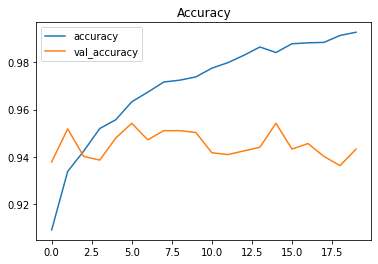

In [ ]:
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
title("Accuracy")
show()

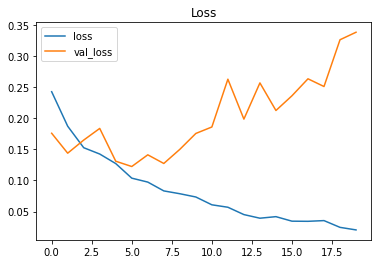

In [ ]:
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
title("Loss")
show()

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Classification_Covid_19/FASNet.h5')

In [ ]:
pred_custom = model.predict(test_images)
pred_custom = np.argmax(pred_custom, axis = 1)

labels_custom = (train_images.class_indices)
labels_custom = dict((v,k) for k, v in labels_custom.items())

pred_custom = [labels_custom[k] for k in pred_custom]

y_test_custom = list(test_df.Labels)
acc = accuracy_score(y_test_custom,pred_custom)

print(f'# Accuracy on the the test: {acc * 100:.2f}%')

# Accuracy on the the test: 34.29%


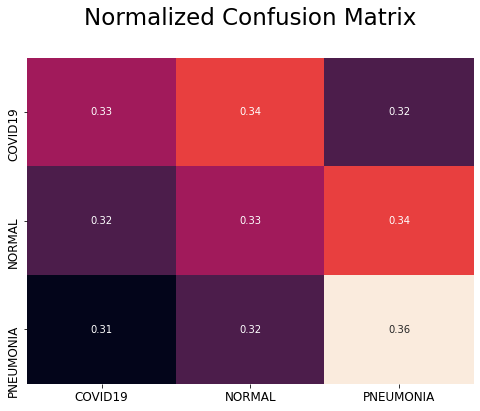

In [ ]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test_custom, pred_custom, normalize = 'true')
figure(figsize = (8,6))
sns.heatmap(cf_matrix, annot = True, xticklabels = sorted(set(y_test_custom)), yticklabels = sorted(set(y_test_custom)), cbar = False)
title('Normalized Confusion Matrix\n ', fontsize=23)
xticks(fontsize=12)
yticks(fontsize=12)
show()

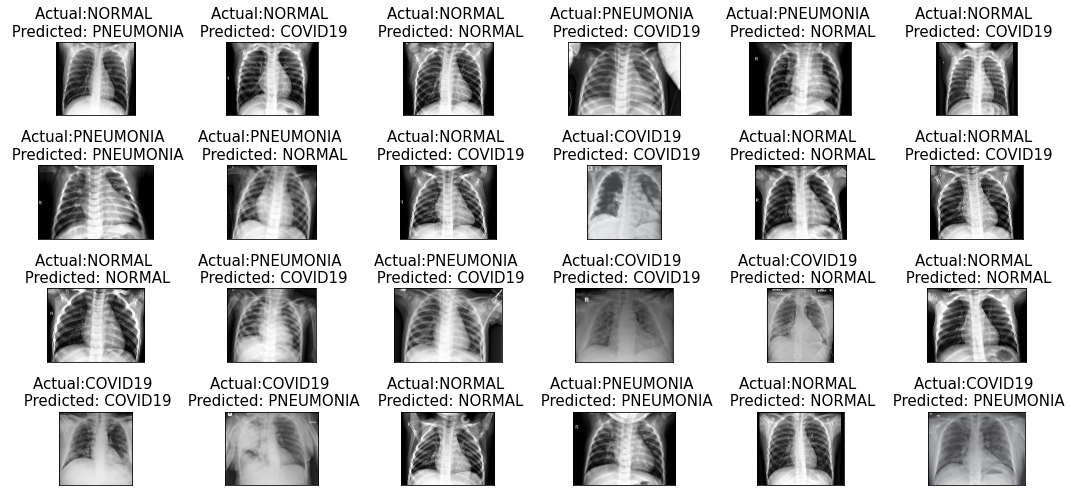

In [ ]:
fig, axes = subplots(nrows = 4,
                     ncols = 6,
                     figsize = (15,7),
                     subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
  ax.imshow(imread(test_df.Filepath.iloc[i]), cmap = 'gray')
  ax.set_title(f"Actual:{test_df.Labels.iloc[i]} \n Predicted: {pred_custom[i]}", fontsize = 15)
tight_layout()
show()

**PHƯƠNG ÁN 3**